In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.compose import make_column_transformer
import tensorflow as tf
import albumentations
import os
import cv2
from sklearn.utils import resample

In [2]:
train=pd.read_csv("../input/fast-furious-and-insured/Fast_Furious_Insured/train.csv")
test=pd.read_csv("../input/fast-furious-and-insured/Fast_Furious_Insured/test.csv")

In [3]:
train.head()

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount
0,img_4513976.jpg,BQ,41500.0,1037.5,2026-12-03,36142.68,0,0.0
1,img_7764995.jpg,BQ,50700.0,1267.5,2025-07-10,12753.00,1,6194.0
2,img_451308.jpg,A,49500.0,1237.5,2022-08-11,43102.68,0,0.0
3,img_7768372.jpg,A,33500.0,837.5,2022-08-02,8453.00,1,7699.0
4,img_7765274.jpg,AC,27600.0,690.0,2026-05-01,6978.00,1,8849.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_path         1399 non-null   object 
 1   Insurance_company  1399 non-null   object 
 2   Cost_of_vehicle    1310 non-null   float64
 3   Min_coverage       1310 non-null   float64
 4   Expiry_date        1399 non-null   object 
 5   Max_coverage       1310 non-null   float64
 6   Condition          1399 non-null   int64  
 7   Amount             1388 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 87.6+ KB


* Image_path:- Path of Image in Fast_Furious_Insured Folder.

* Insurance_company:- Represents masked values of some insurance companies.

* Cost of Vehicle:- Represents the cost of a vehicle present in the image.

* Min_coverage:- Represents the minimum coverage provided by an insurance company.

* Expiry_date:- Represents the expiry date of the insurance.

* Max_coverage:- Represents the maximum coverage provided by an insurance company.

* Condition:-Represents whether a vehicle is damaged

* Amount:- Represents the insurance amount of a vehicle

In [5]:
train.describe()

,Cost_of_vehicle,Min_coverage,Max_coverage,Condition,Amount
count,1310.000000,1310.000000,1310.000000,1399.000000,1388.000000
mean,37454.274809,936.356870,11242.925160,0.929235,4117.144092
std,8921.428143,223.035704,7163.735952,0.256523,3151.516223
min,11100.000000,277.500000,2853.000000,0.000000,-999.000000
25%,29800.000000,745.000000,7603.000000,1.000000,1641.750000
50%,37300.000000,932.500000,9678.000000,1.000000,4070.000000
75%,45175.000000,1129.375000,11703.000000,1.000000,6039.500000
max,53500.000000,1337.500000,46495.680000,1.000000,59844.000000


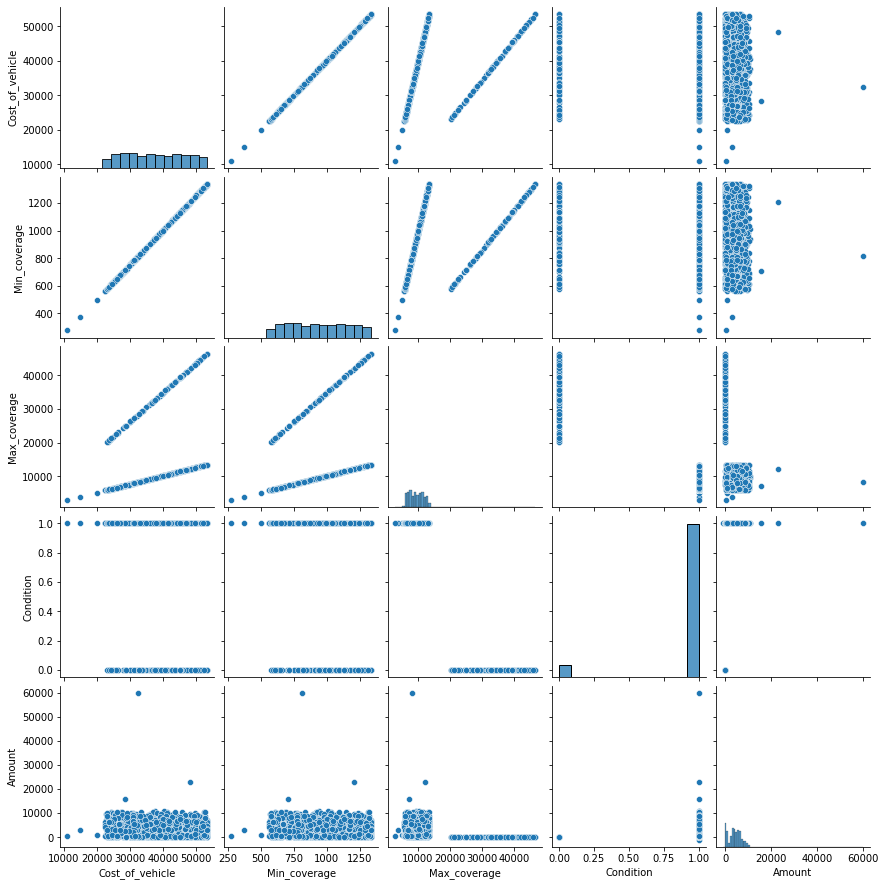

In [6]:
sns.pairplot(train)

* The Condition column  is highly Imbalanced 

* There is a clear Decision Boundry based on Max_coverage which seprates 2 classes.

In [7]:
train.loc[train.Amount>train.Cost_of_vehicle]

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount
1324,img_7767995.jpg,AA,32500.0,812.5,2022-03-03,8203.0,1,59844.0


This Amount is clear a mistake because Insurance Amount can never be greather then Cost_of_vehicle

In [8]:
train.loc[train['Amount']>train['Cost_of_vehicle'],'Amount']=train.Amount.median()

<AxesSubplot:>

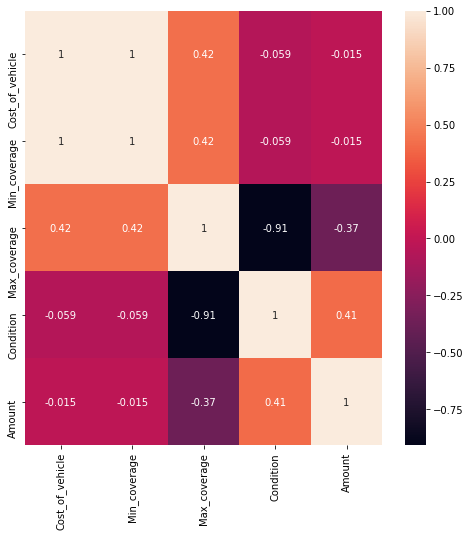

In [9]:
plt.figure(figsize=(8,8))
sns.heatmap(train.corr(),annot=True)

In [10]:
train.loc[(train.Max_coverage>13460)]['Condition'].value_counts()

0    97
Name: Condition, dtype: int64

In [11]:
test['Condition']=test['Max_coverage'].apply(lambda x: 0 if x>13460 else 1)

In [12]:
test['Condition'].value_counts()

1    557
0     43
Name: Condition, dtype: int64

In [13]:
train=train.fillna(method='bfill',axis=0).fillna(0)
features_num = ['Cost_of_vehicle', 'Min_coverage', 'Max_coverage']
features_cat = ['Insurance_company']
le= LabelEncoder()   
train['Insurance_company'] = le.fit_transform(train['Insurance_company'])
test['Insurance_company'] = le.transform(test['Insurance_company'])
preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
)

y = train['Amount']
train_imputed = train.loc[:,['Cost_of_vehicle', 'Min_coverage', 'Max_coverage', 'Insurance_company']]
X = preprocessor.fit_transform(train_imputed)

test_imputed = test.loc[:,['Cost_of_vehicle', 'Min_coverage',  'Max_coverage', 'Insurance_company']]
test_X = preprocessor.transform(test_imputed)
train_X, val_X, train_y, val_y = train_test_split(X,y,random_state=1,test_size=0.2)
rf_model = RandomForestRegressor(random_state=1, n_estimators = 1000, max_depth=3)
rf_model.fit(train_X,train_y)
val_preds = rf_model.predict(val_X)
rf_val_mae = mean_absolute_error(val_y,val_preds)

print("Validation MAE {}".format(rf_val_mae))

Validation MAE 2041.6124670960241


In [14]:
test_Y=rf_model.predict(test_X)

In [15]:
sample_submission=pd.read_csv("../input/thesese/submission.csv")
sample_submission['Condition']=test['Condition']
sample_submission['Amount']=test_Y

In [16]:
sample_submission.to_csv("submission.csv",index=False)

# DEEP LEARNING  MODEL

In [17]:
train=pd.read_csv("../input/fast-furious-and-insured/Fast_Furious_Insured/train.csv")
test=pd.read_csv("../input/fast-furious-and-insured/Fast_Furious_Insured/test.csv")
train_folder="../input/fast-furious-and-insured/Fast_Furious_Insured/trainImages/"
test_folder="../input/fast-furious-and-insured/Fast_Furious_Insured/testImages/"
batch_size=32
img_size=224


In [18]:
class_0=train[train['Condition']==0]
class_1=train[train['Condition']==1]
class_0=resample(class_0,n_samples=len(class_1),random_state=42)
df=pd.concat((class_0,class_1))
df=df.sample(frac=1)

augment=albumentations.Compose([
    albumentations.HorizontalFlip(),
    albumentations.VerticalFlip(),
    albumentations.ShiftScaleRotate(),
    albumentations.HueSaturationValue(hue_shift_limit=10,sat_shift_limit=10,val_shift_limit=10),
    albumentations.RandomBrightnessContrast(),
    albumentations.OneOf([
        albumentations.GaussNoise(),
        albumentations.GaussianBlur(),
        albumentations.MotionBlur()
    ],p=0.3)
    
    
])
X=np.zeros((len(df),img_size,img_size,3))
y=np.zeros((len(df),1))
X_test=np.zeros((len(test),img_size,img_size,3))
a=0
for i,j in df.iterrows():
    path=os.path.join(train_folder,j['Image_path'])
    image=cv2.imread(path)
    if(j['Condition']==0):
        image=augment(image=image)['image']
    image=cv2.resize(image,(img_size,img_size))
    image=image.astype("float32")/255.0
    X[a,:]=image
    y[a,:]=j['Condition']
    a+=1
a=0    
for i,j in test.iterrows():
    path=os.path.join(test_folder,j['Image_path'])
    image=cv2.imread(path)
    image=cv2.resize(image,(img_size,img_size))
    image=image.astype("float32")/255.0
    X_test[a,:]=image
    a+=1
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=42)
   

In [19]:
print(len(y_train[y_train==1]))
print(len(y_train[y_train==0]))

1043
1037


In [20]:
LR_START = 0.00001
LR_MAX = 0.00005
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_DECAY = .8

def lr_schedule(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr


lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose = True)
es=tf.keras.callbacks.EarlyStopping(patience=3)

In [21]:
Model=tf.keras.applications.DenseNet169(input_shape=(img_size,img_size,3),include_top=False)
Model.trainable=True
model=tf.keras.models.Sequential([
    Model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[tf.keras.metrics.BinaryAccuracy()])

51879936/51877672 [==============================] - 1s 0us/step


In [22]:
model.fit(X_train,y_train,epochs=50,validation_data=(X_val,y_val),callbacks=[lr_callback,es])

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
65/65 [==============================] - 39s 306ms/step - loss: 0.7183 - binary_accuracy: 0.5667 - val_loss: 0.4463 - val_binary_accuracy: 0.8404
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
65/65 [==============================] - 16s 252ms/step - loss: 0.3744 - binary_accuracy: 0.8475 - val_loss: 0.2565 - val_binary_accuracy: 0.9250
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
65/65 [==============================] - 16s 251ms/step - loss: 0.1852 - binary_accuracy: 0.9464 - val_loss: 0.1387 - val_binary_accuracy: 0.9635
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
65/65 [==============================] - 16s 249ms/step - loss: 0.0903 - binary_accuracy: 0.9839 - val_loss: 0.0811 - val_binary_accuracy: 0.9788
Epoch 5/50

Epoch 00005: LearningRateSchedule

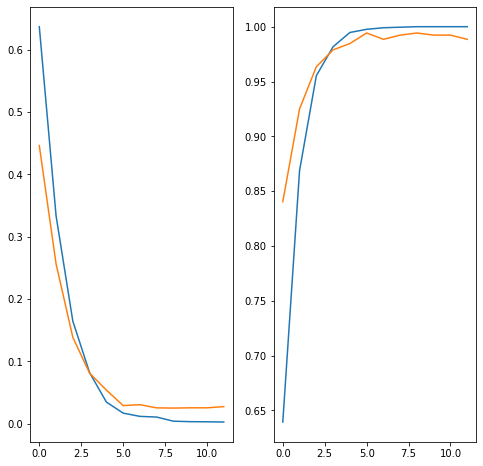

In [23]:
history=pd.DataFrame(model.history.history)
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(history[['loss','val_loss']])
plt.subplot(1,2,2)
plt.plot(history[['binary_accuracy','val_binary_accuracy']])

In [24]:
predictions=model.predict(X_test)
predictions=np.where(predictions>0.5,1,0)
sample_submission['Condition']=predictions
sample_submission.to_csv("submission.csv",index=False)